# Custom OCR - text recognition

# Importing the libraries

In [9]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
import imutils

In [2]:
#from google.colab.patches import cv2_imshow
def cv2_imshow(img, to_rgb=True):
    if to_rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR -> RGB
    plt.imshow(img)
    plt.show()

# Loading the neural network

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
DATA_PATH = "./../material/"

In [7]:
network = load_model(DATA_PATH+'Models/network')
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

# Loading the test image

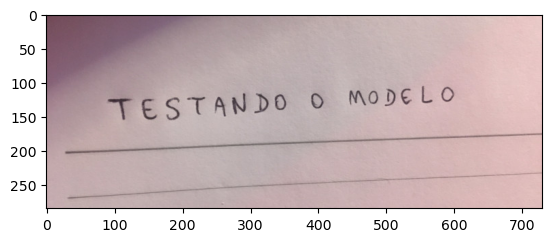

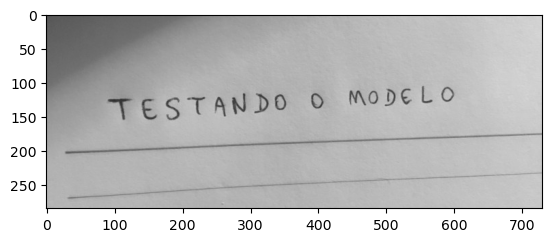

In [10]:
img = cv2.imread(DATA_PATH+'Images/test-manuscript01.jpg')
cv2_imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

# Pre-processing the image

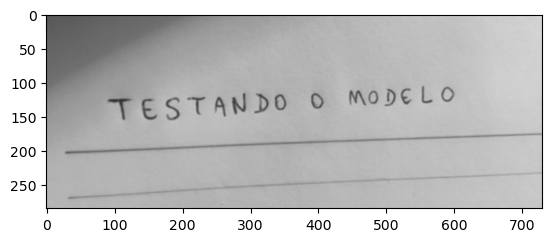

In [11]:
blur = cv2.GaussianBlur(gray, (3,3), 0)
cv2_imshow(blur)

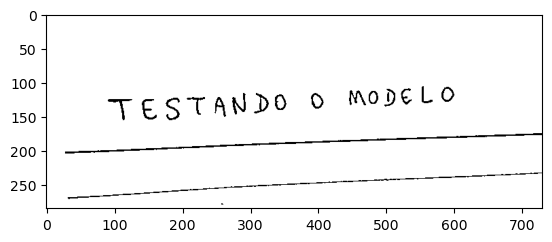

In [12]:
adaptive = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
cv2_imshow(adaptive)

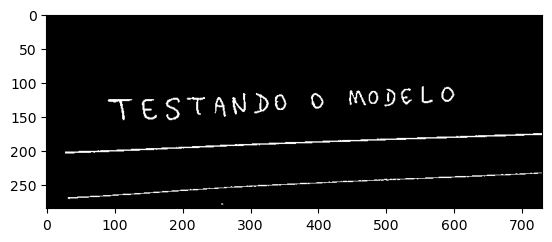

In [13]:
invertion = 255 - adaptive
cv2_imshow(invertion)

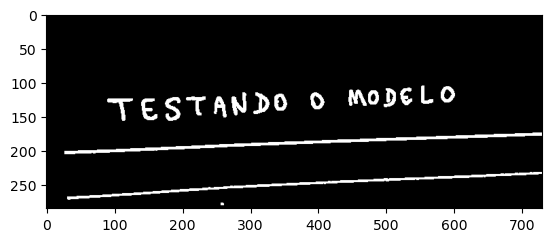

In [14]:
dilation = cv2.dilate(invertion, np.ones((3,3)))
cv2_imshow(dilation)

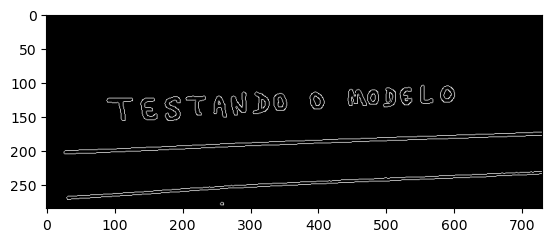

In [15]:
# Edge detection
edges = cv2.Canny(dilation, 40, 150)
cv2_imshow(edges)

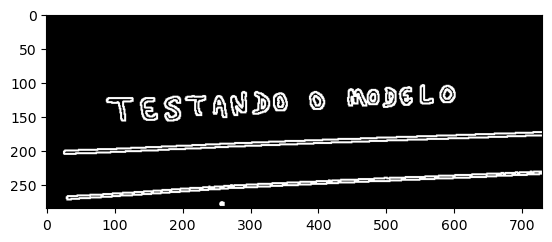

In [16]:
dilation = cv2.dilate(edges, np.ones((3,3)))
cv2_imshow(dilation)

# Contour detection

In [18]:
# One way of isolating disconnected blobs consists in computing
# the contours of the blobs (= letters); then, we can find the bounding box of the
# contours. To that end, we find the edges first, then contours, and finally the bboxes.
# Another option is to use cv2.connectedComponentsWithStats() directly
# on the thresholded image.
def find_contours(img):
    # Note that we are getting external contours
    # We need to take into account all possible paramaters
    # of findContours()...
    conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    conts = imutils.grab_contours(conts)
    # Note we are sorting from left-to-right
    conts = sort_contours(conts, method = 'left-to-right')[0]
    
    return conts

In [19]:
conts = find_contours(dilation.copy())

In [24]:
#conts

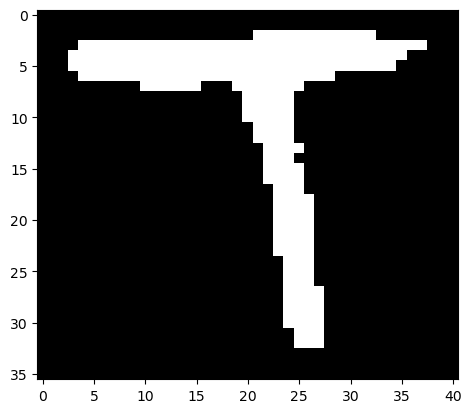

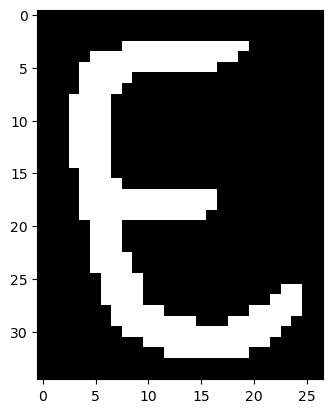

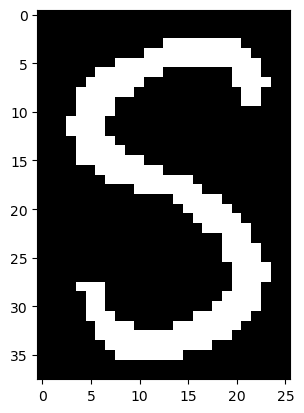

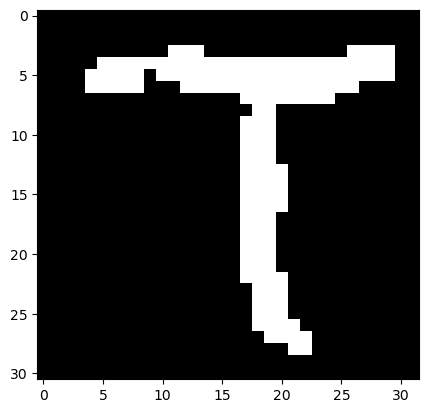

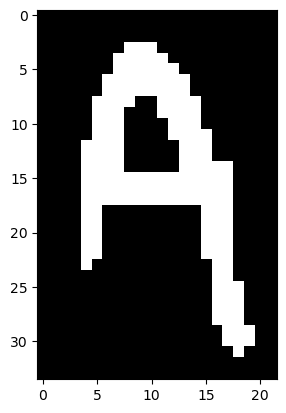

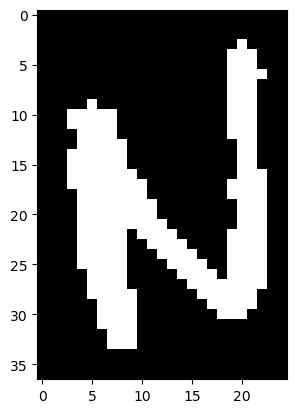

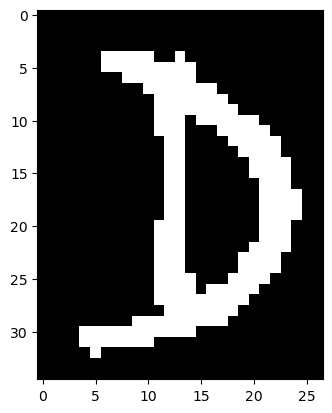

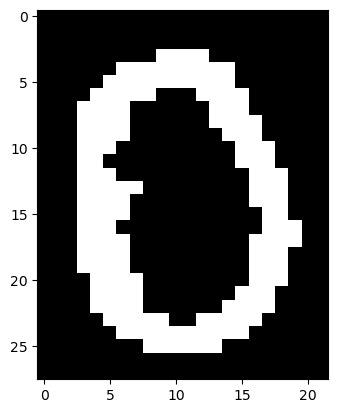

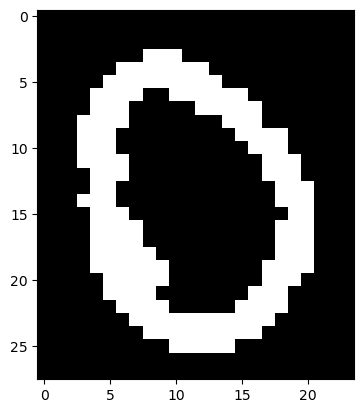

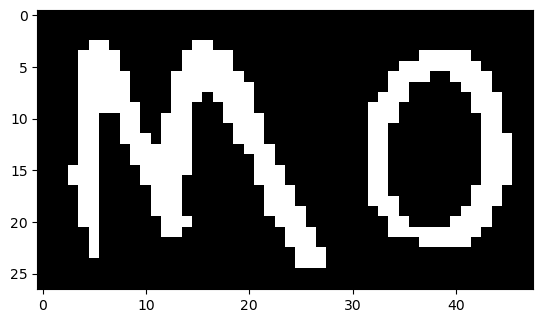

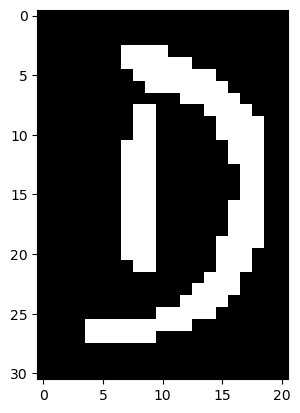

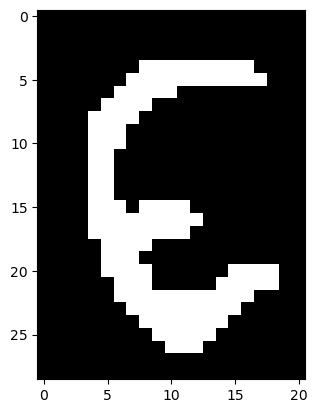

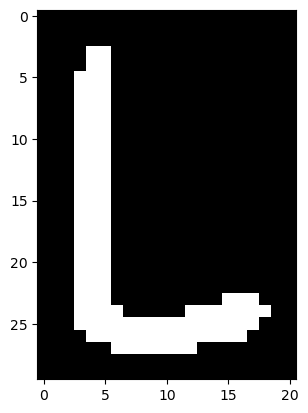

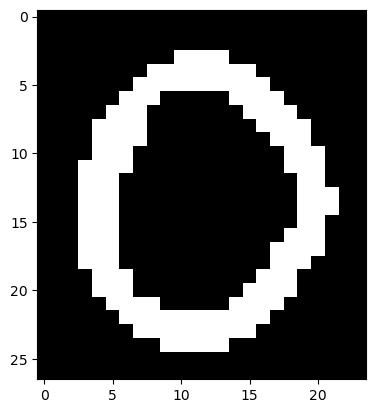

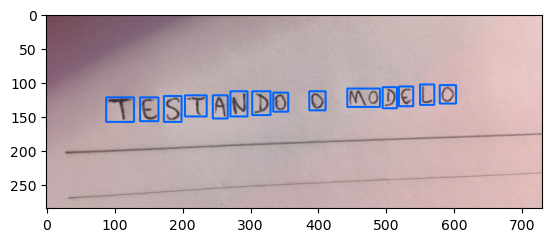

In [23]:
# After the bounding boxes have been found
# we extract the ROIs that contain the letters
min_w, max_w = 4, 160
min_h, max_h = 14, 140
img_copy = img.copy()
for c in conts:
    #print(c)
    (x, y, w, h) = cv2.boundingRect(c)
    #print(x, y, w, h)
    if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
        roi = gray[y:y+h, x:x+w]
        #cv2_imshow(roi)
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        cv2_imshow(thresh)
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255, 100, 0), 2)
cv2_imshow(img_copy)

# Processing the detected characters

## ROI extraction


In [25]:
def extract_roi(img):
    roi = img[y:y + h, x:x + w]
    return roi

## Thresholding

In [26]:
def thresholding(img):
    thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    return thresh

## Resizing

In [27]:
def resize_img(img, w, h):
    if w > h:
      resized = imutils.resize(img, width = 28)
    else:
      resized = imutils.resize(img, height = 28)
    
    (h, w) = resized.shape
    dX = int(max(0, 28 - w) / 2.0)
    dY = int(max(0, 28 - h) / 2.0)
    
    filled = cv2.copyMakeBorder(resized, top=dY, bottom=dY, right=dX, left=dX, borderType=cv2.BORDER_CONSTANT, value = (0,0,0))
    filled = cv2.resize(filled, (28,28))
    return filled

245 119 22 34


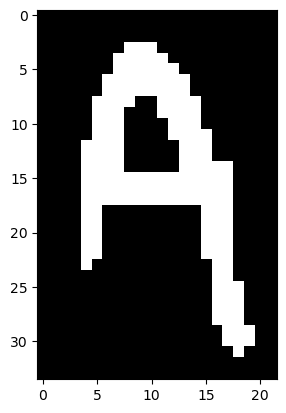

34 22


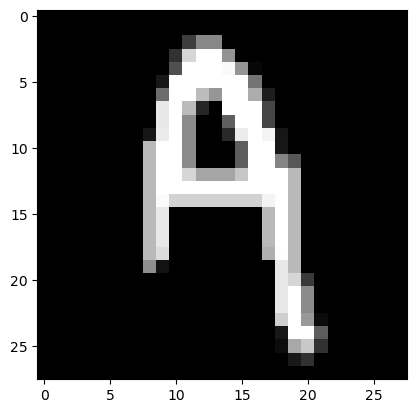

(28, 28)


In [28]:
(x, y, w, h) = cv2.boundingRect(conts[6])
print(x, y, w, h)
test_img = thresholding(gray[y:y+h, x:x+w])
cv2_imshow(test_img)
(h, w) = test_img.shape
print(h, w)
test_img2 = resize_img(test_img, w, h)
cv2_imshow(test_img2)
print(test_img2.shape)

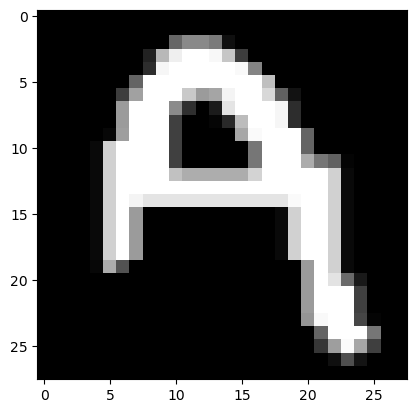

In [29]:
cv2_imshow(cv2.resize(test_img, (28,28)))

## Normalization

In [30]:
def normalization(img):
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis = -1)
    return img

In [31]:
test_img2.shape, normalization(test_img2).shape

((28, 28), (28, 28, 1))

## Processing the detections

In [32]:
characters = []

In [33]:
def process_box(gray, x, y, w, h):
    roi = extract_roi(gray)
    thresh = thresholding(roi)
    (h, w) = thresh.shape
    resized = resize_img(thresh, w, h)
    cv2_imshow(resized)
    normalized = normalization(resized)
    characters.append((normalized, (x, y, w, h)))

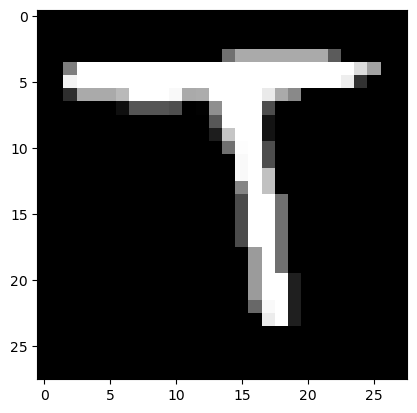

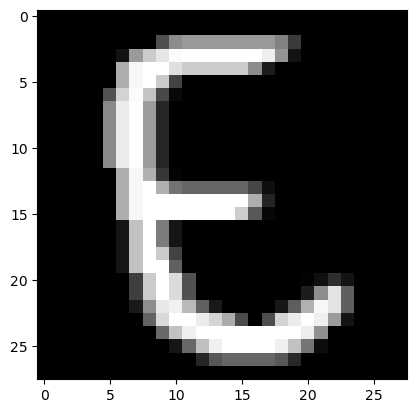

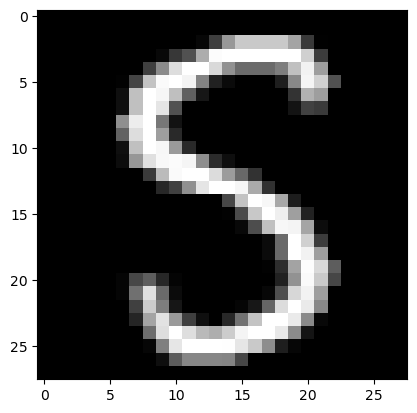

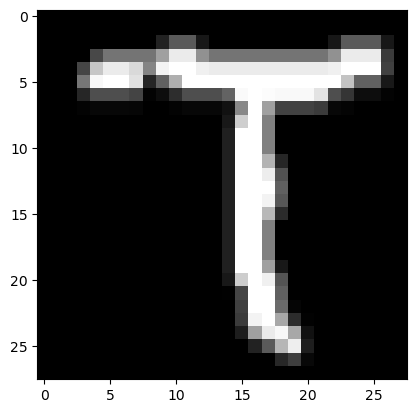

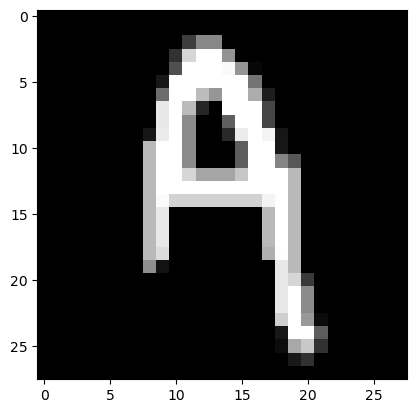

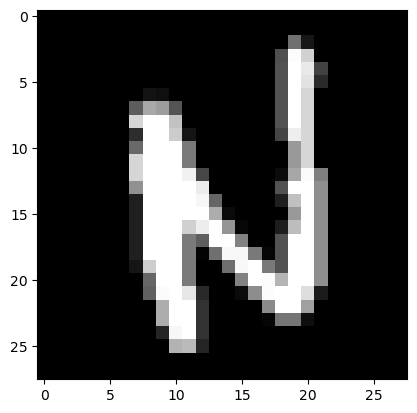

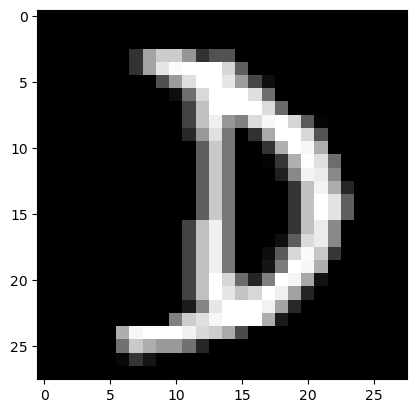

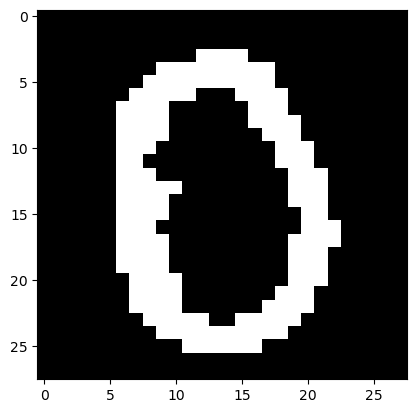

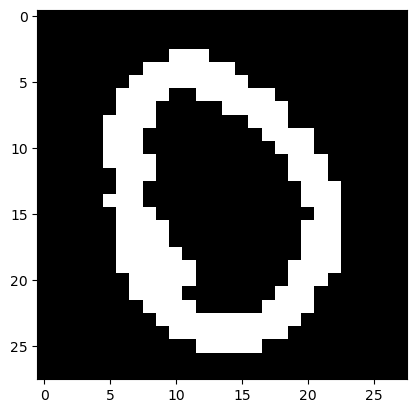

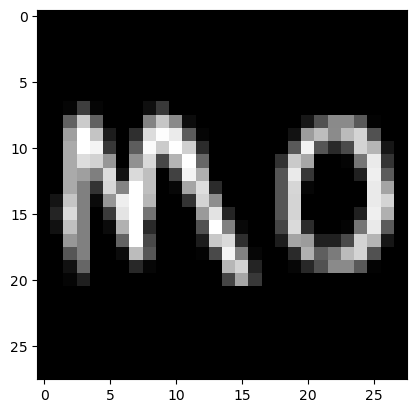

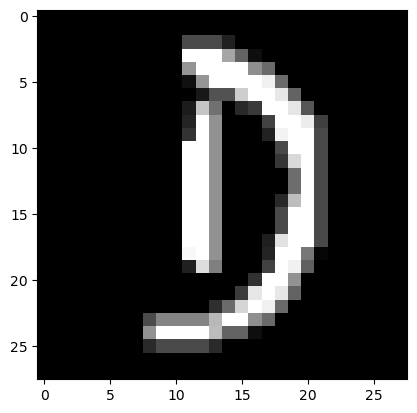

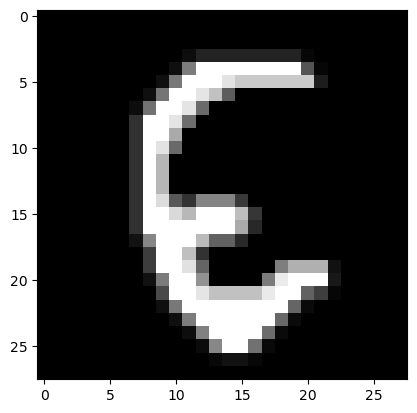

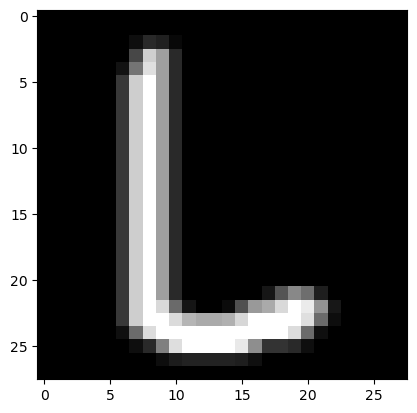

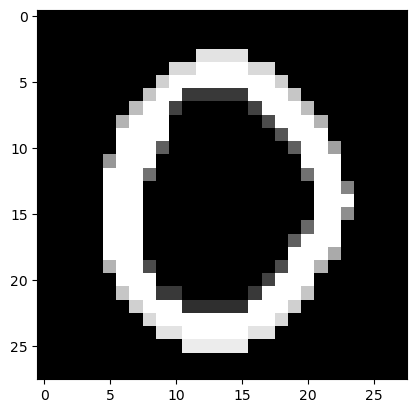

In [34]:
for c in conts:
    #print(c)
    (x, y, w, h) = cv2.boundingRect(c)
    if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
        process_box(gray, x, y, w, h)

In [35]:
characters[0]

(array([[[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ]],
 
        [[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
        

In [36]:
boxes = [box[1] for box in characters]
boxes

[(88, 122, 41, 36),
 (138, 122, 27, 35),
 (173, 120, 26, 38),
 (204, 119, 32, 31),
 (245, 119, 22, 34),
 (271, 113, 25, 37),
 (303, 113, 27, 35),
 (334, 115, 22, 28),
 (387, 113, 24, 28),
 (443, 109, 48, 27),
 (495, 107, 21, 31),
 (519, 106, 21, 29),
 (550, 103, 21, 30),
 (579, 104, 24, 27)]

In [37]:
pixels = np.array([pixel[0] for pixel in characters], dtype = 'float32')

In [38]:
pixels

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

# Recognition of characters

In [39]:
digits = '0123456789'
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
characters_list = digits + letters
characters_list = [l for l in characters_list]

In [40]:
print(characters_list)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [41]:
pixels[0].shape

(28, 28, 1)

In [42]:
pixels.shape

(14, 28, 28, 1)

In [43]:
predictions = network.predict(pixels)

1/1 [==============================] - 0s 443ms/step


In [44]:
predictions

array([[6.42186446e-16, 2.21650325e-08, 2.71311862e-11, 2.39621894e-15,
        8.27246535e-11, 7.60040990e-08, 4.05780531e-12, 6.75778545e-04,
        3.20631566e-09, 2.16117146e-09, 1.91804688e-13, 6.88758356e-11,
        1.08010552e-08, 1.22510502e-10, 1.04472084e-10, 9.34329111e-13,
        5.39300338e-08, 3.49604590e-12, 6.51504461e-10, 1.05939389e-05,
        6.22769463e-08, 1.24172103e-10, 3.79408066e-13, 1.62339532e-12,
        5.80905501e-09, 6.13470108e-11, 1.20422472e-21, 1.84625020e-13,
        2.01447170e-09, 9.99254763e-01, 7.22633672e-07, 3.06296410e-15,
        7.73809596e-16, 3.08319130e-08, 5.73665020e-05, 5.28718317e-07],
       [2.15694200e-16, 3.03159736e-21, 1.15997160e-15, 1.17366845e-28,
        2.58327244e-18, 2.74514127e-11, 8.46175647e-12, 6.96459257e-20,
        7.95660846e-12, 1.49924916e-15, 2.55846912e-19, 1.25416941e-10,
        2.87038713e-08, 6.82321360e-14, 1.00000000e+00, 2.24258727e-08,
        2.34532237e-11, 1.33085089e-18, 2.92871232e-21, 2.04122

In [45]:
predictions.shape

(14, 36)

In [46]:
boxes

[(88, 122, 41, 36),
 (138, 122, 27, 35),
 (173, 120, 26, 38),
 (204, 119, 32, 31),
 (245, 119, 22, 34),
 (271, 113, 25, 37),
 (303, 113, 27, 35),
 (334, 115, 22, 28),
 (387, 113, 24, 28),
 (443, 109, 48, 27),
 (495, 107, 21, 31),
 (519, 106, 21, 29),
 (550, 103, 21, 30),
 (579, 104, 24, 27)]

T  ->  99.92547631263733


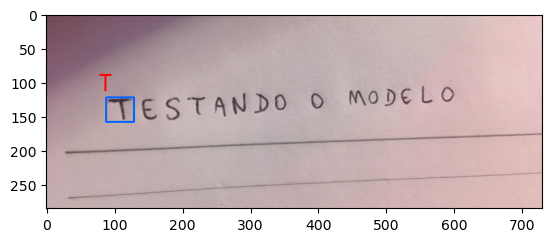

E  ->  100.0


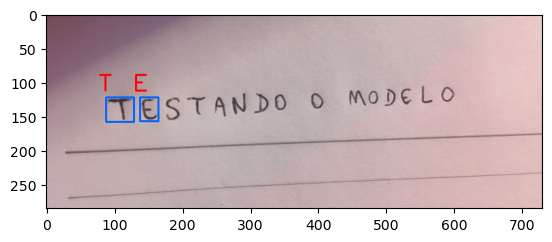

S  ->  95.85323333740234


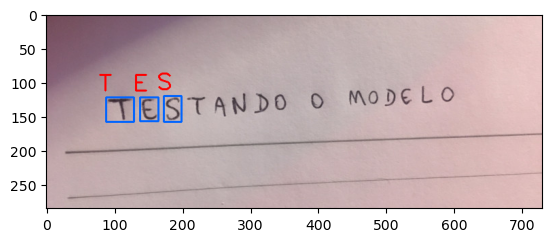

T  ->  99.98064637184143


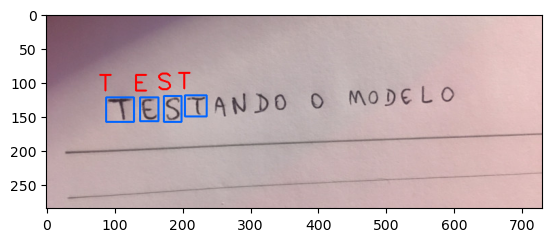

A  ->  99.9979019165039


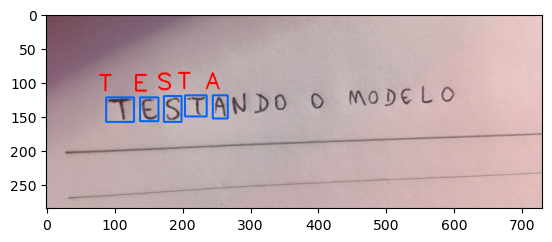

N  ->  99.99876022338867


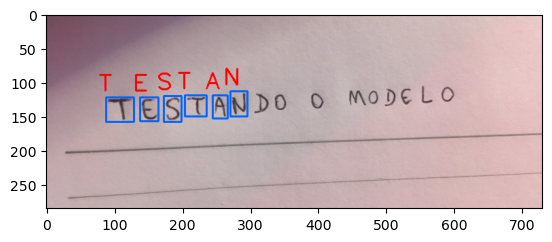

D  ->  99.9924898147583


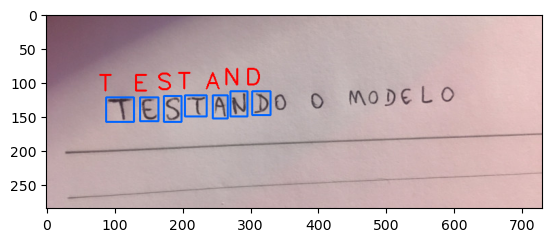

0  ->  44.61866021156311


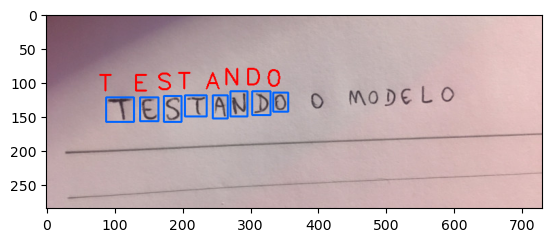

0  ->  59.7159743309021


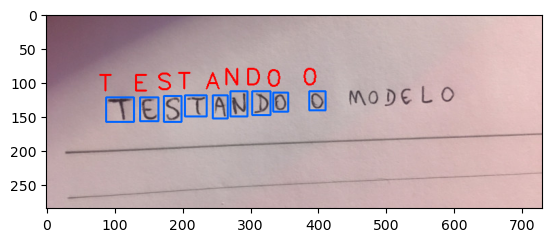

M  ->  53.95532250404358


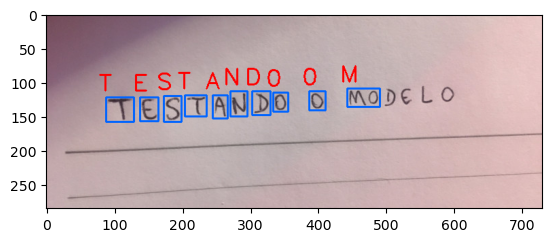

D  ->  99.73588585853577


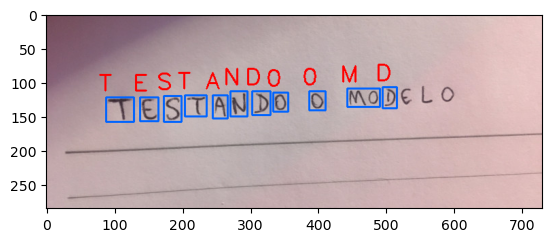

E  ->  99.0382730960846


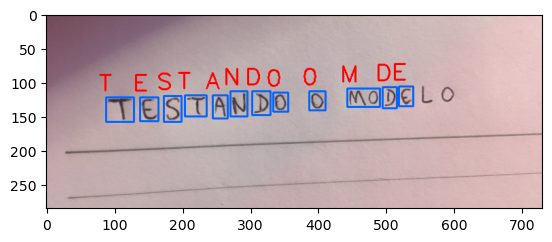

L  ->  99.99897480010986


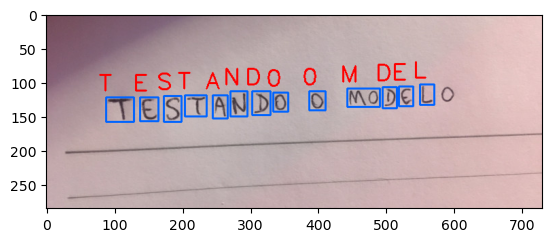

0  ->  78.80920171737671


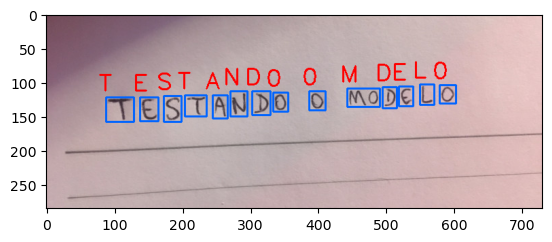

In [48]:
img_copy = img.copy()
for (prediction, (x, y, w, h)) in zip(predictions, boxes):
    i = np.argmax(prediction)
    #print(i)
    probability = prediction[i]
    #print(probability)
    character = characters_list[i]
    #print(character)
    
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255,100,0), 2)
    cv2.putText(img_copy, character, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0,0,255), 2)
    print(character, ' -> ', probability * 100)
    
    cv2_imshow(img_copy)

In [49]:
def extract_roi(img, margin=2):
    roi = img[y - margin:y + h, x - margin:x + w + margin]
    return roi

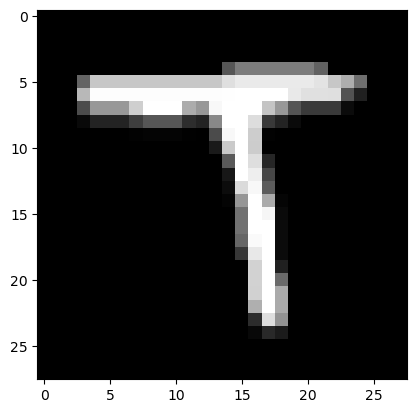

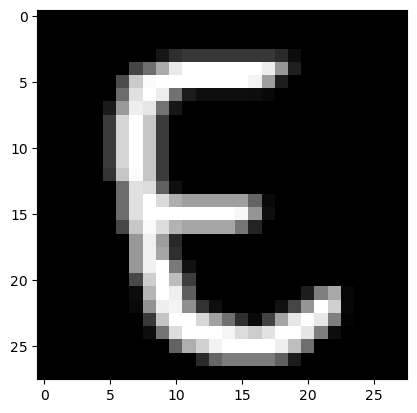

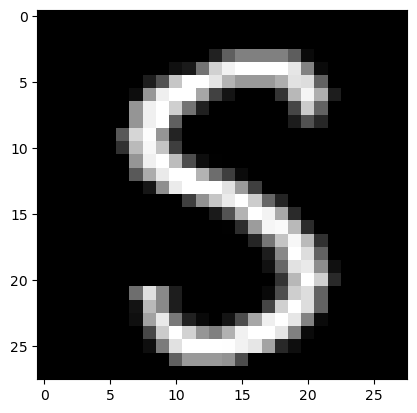

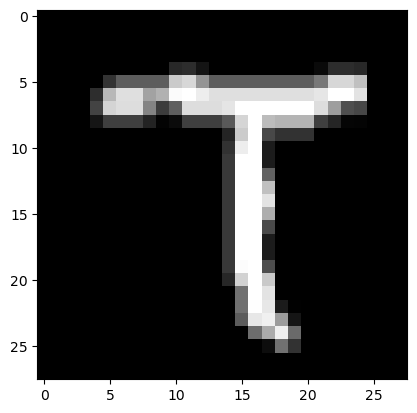

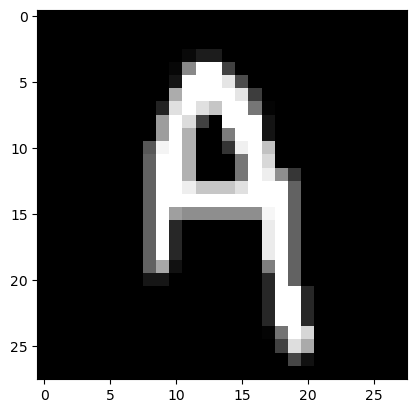

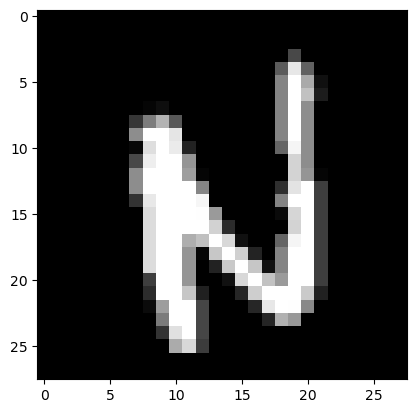

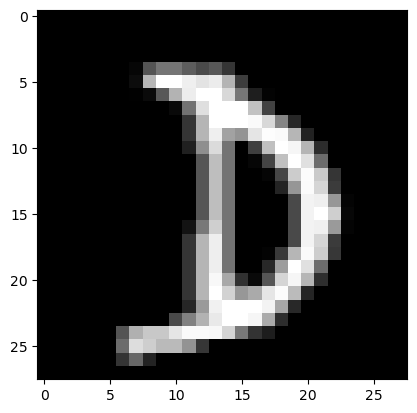

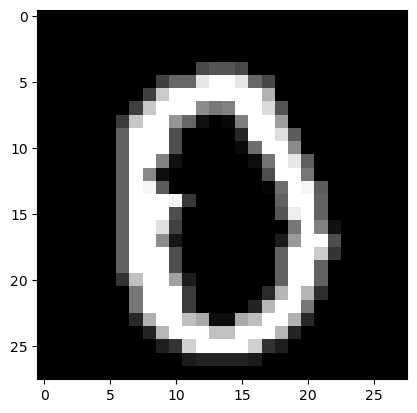

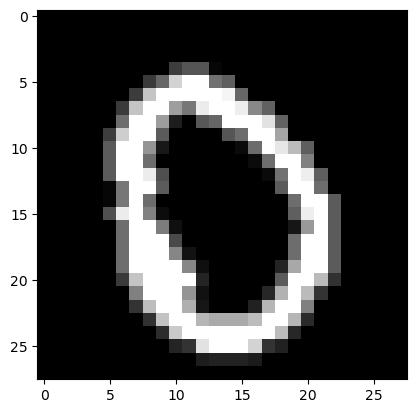

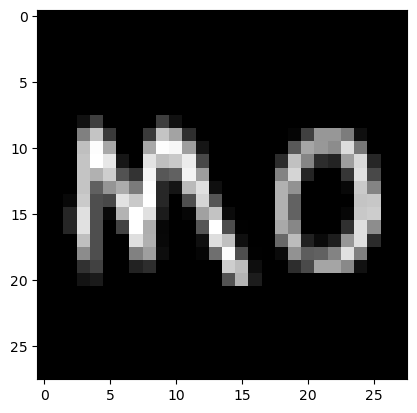

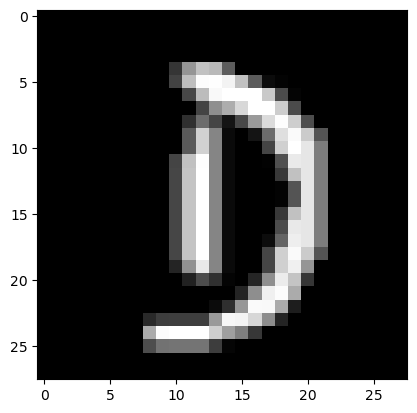

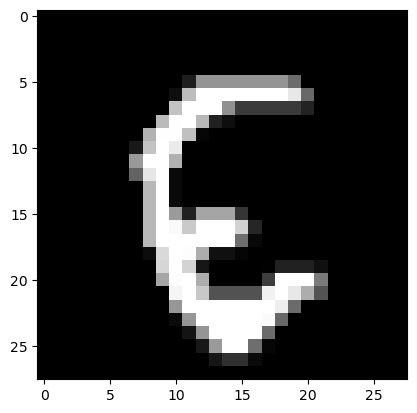

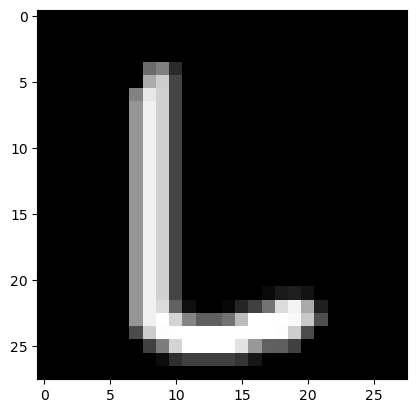

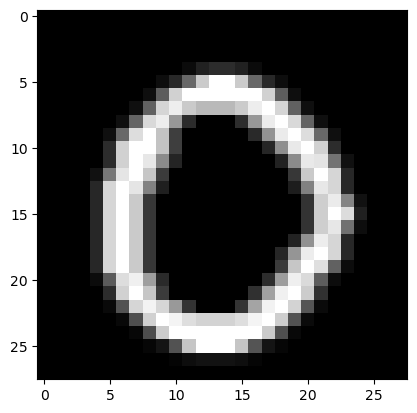

In [50]:
conts = find_contours(dilation.copy())
characters = []
for c in conts:
  (x, y, w, h) = cv2.boundingRect(c)
  if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
    process_box(gray, x, y, w, h)

In [51]:
boxes = [b[1] for b in characters]
pixels = np.array([p[0] for p in characters], dtype='float32')
predictions = network.predict(pixels)

1/1 [==============================] - 0s 82ms/step


T  ->  99.98507499694824


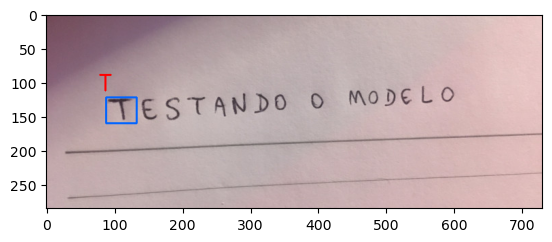

E  ->  100.0


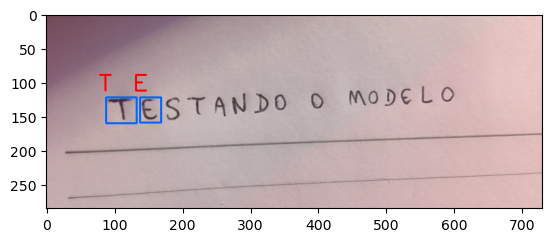

S  ->  97.68903255462646


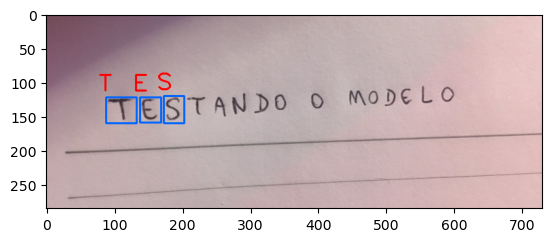

T  ->  99.97257590293884


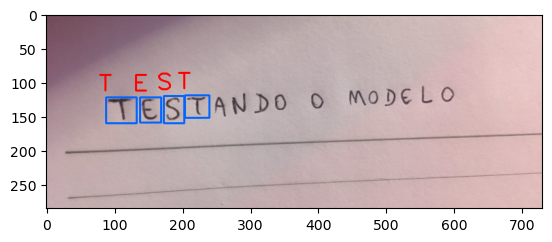

A  ->  99.99572038650513


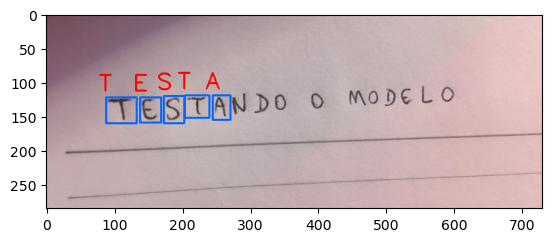

N  ->  99.9751627445221


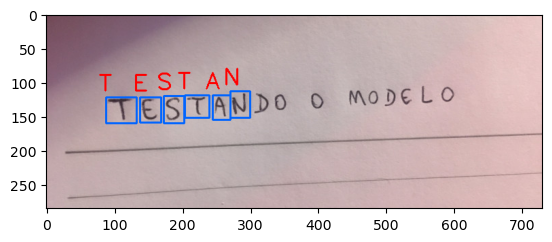

D  ->  99.99972581863403


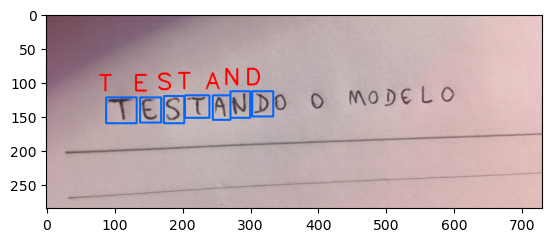

0  ->  46.62533402442932


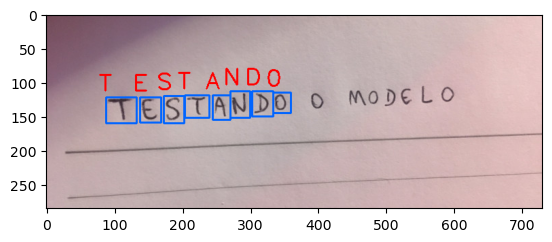

0  ->  82.96228647232056


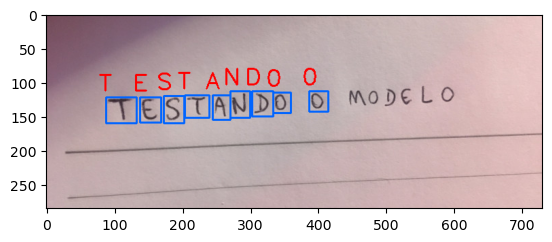

M  ->  95.9153413772583


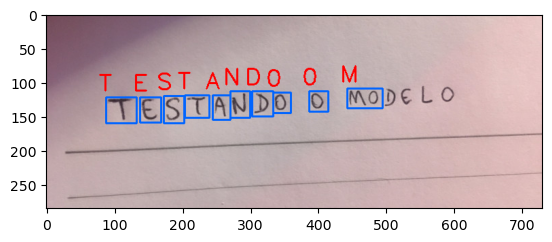

D  ->  99.49016571044922


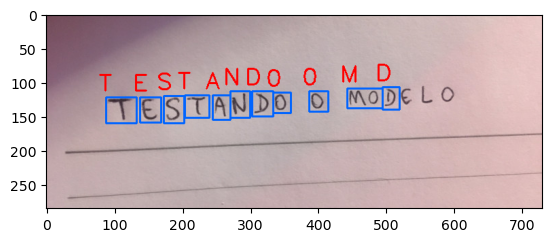

E  ->  99.50670003890991


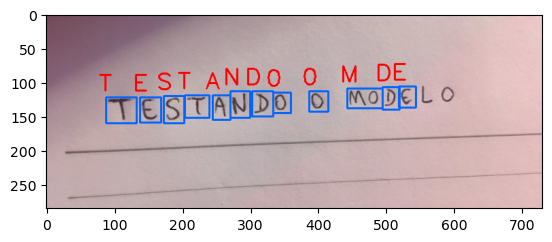

L  ->  99.99955892562866


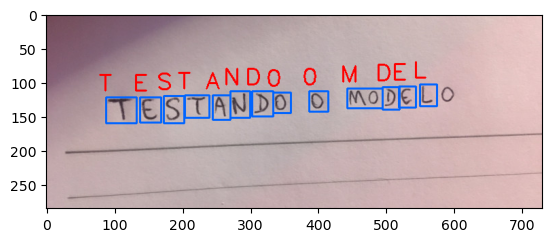

0  ->  94.61226463317871


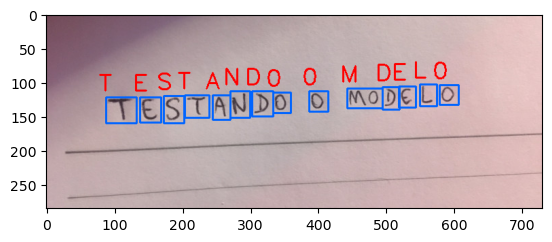

In [52]:
img_copy = img.copy()
for (prediction, (x, y, w, h)) in zip(predictions, boxes):
    i = np.argmax(prediction)
    probability = prediction[i]
    character = characters_list[i]
    
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255,100,0), 2)
    cv2.putText(img_copy, character, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0,0,255), 2)
    print(character, ' -> ', probability * 100)
    
    cv2_imshow(img_copy)

# Other tests

In [53]:
def preprocess_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 7)
    edges = cv2.Canny(blur, 40, 150)
    dilation = cv2.dilate(edges, np.ones((3,3)))  
    return gray, dilation

In [54]:
def prediction(predictions, characters_list):
    i = np.argmax(predictions)
    probability = predictions[i]
    character = characters_list[i]
    return i, probability, character

In [55]:
def draw_img(img_cp, character):
    cv2.rectangle(img_cp, (x, y), (x + w, y + h), (255, 100, 0), 2)
    cv2.putText(img_cp, character, (x - 10, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 0, 255), 2)

## Problems with 0 and O, 1 an I, 5 and S

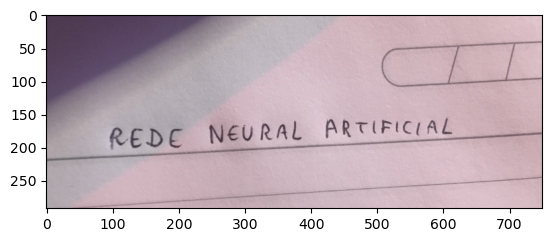

In [56]:
img = cv2.imread(DATA_PATH+'Images/test_manuscript02.jpg')
cv2_imshow(img)

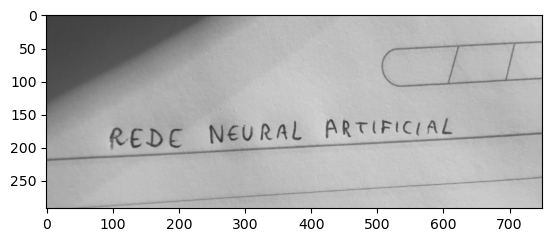

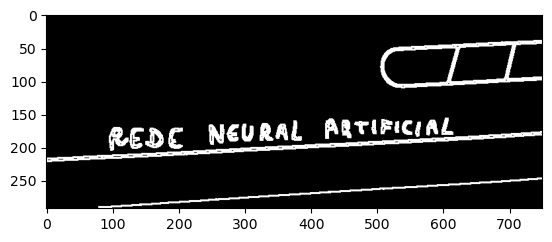

In [57]:
gray, processed_img = preprocess_img(img)
cv2_imshow(gray)
cv2_imshow(processed_img)

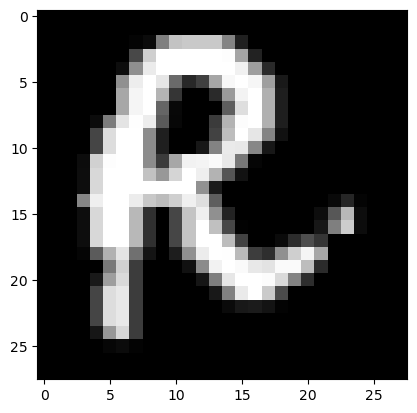

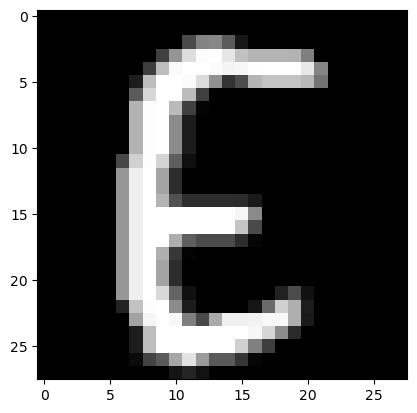

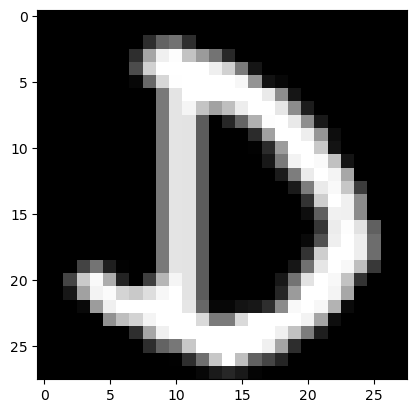

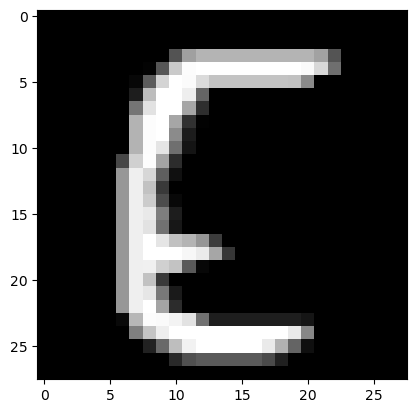

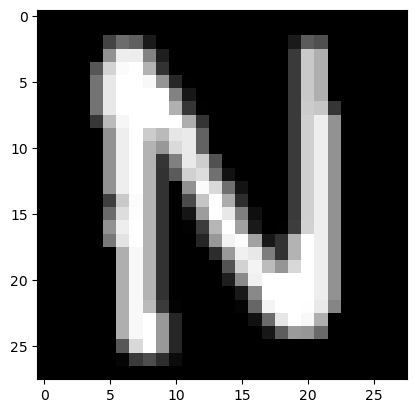

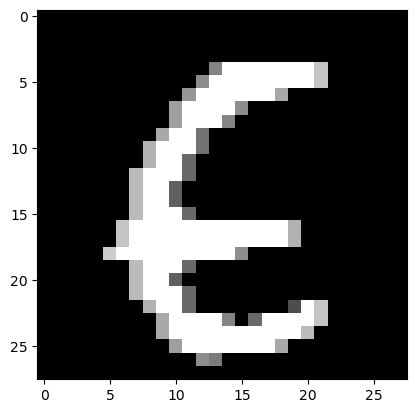

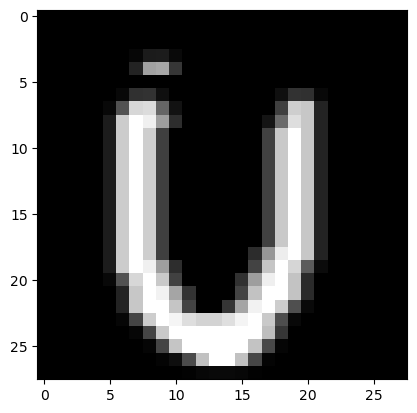

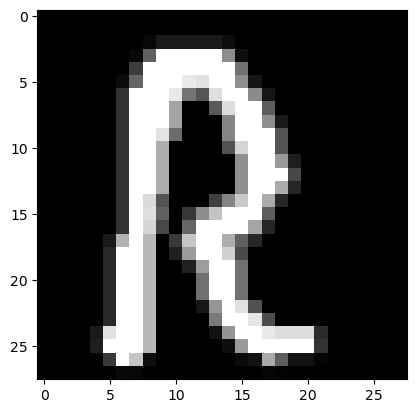

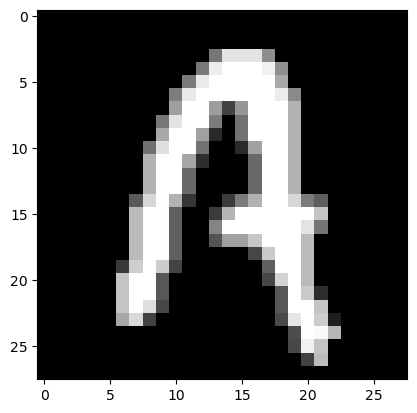

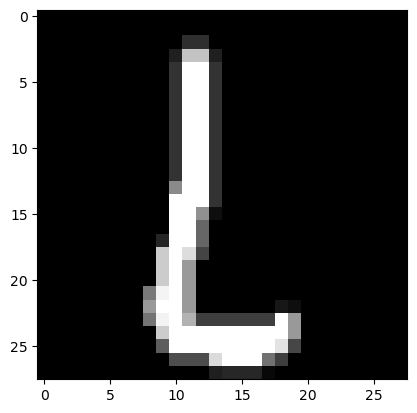

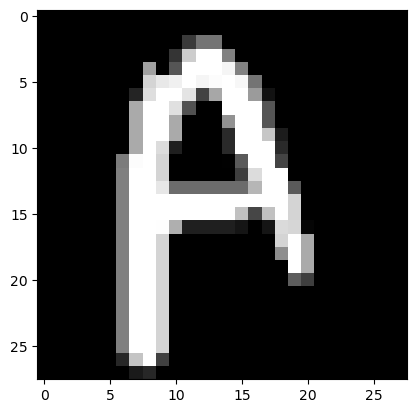

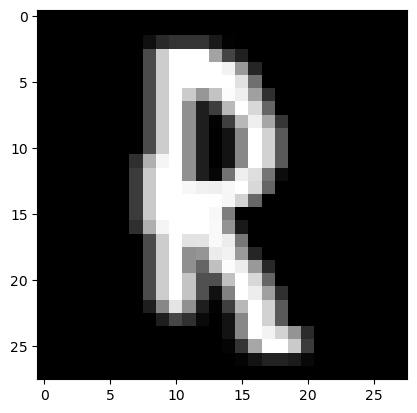

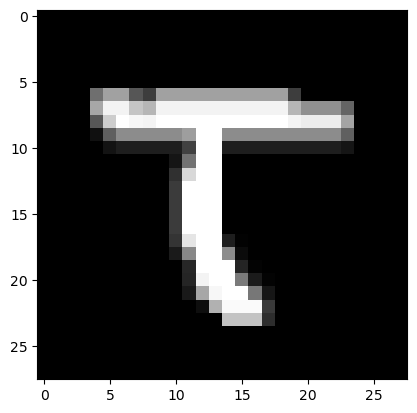

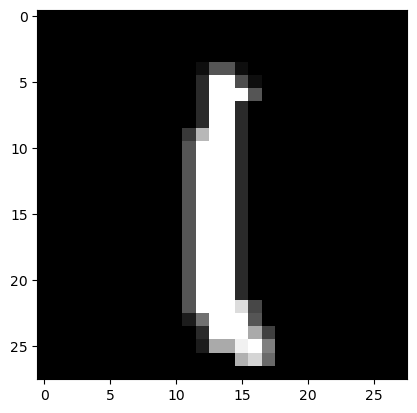

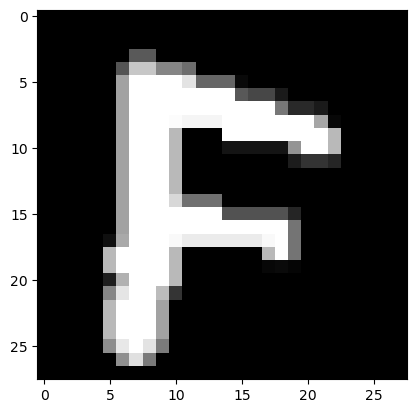

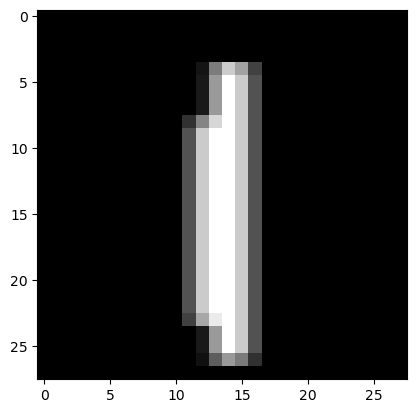

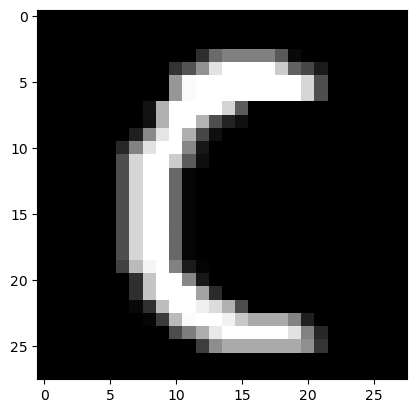

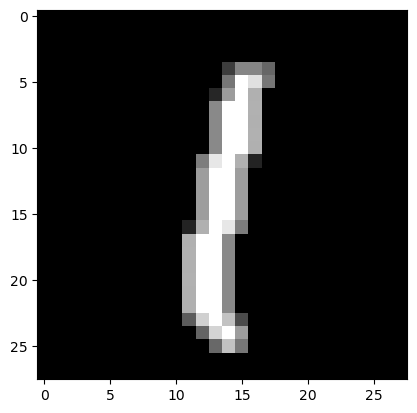

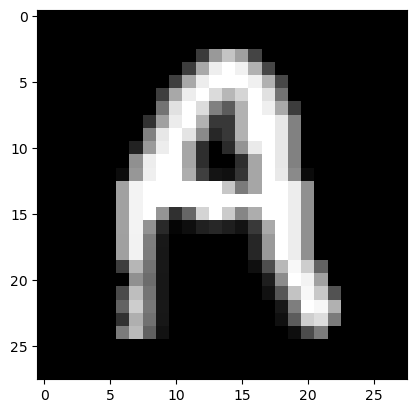

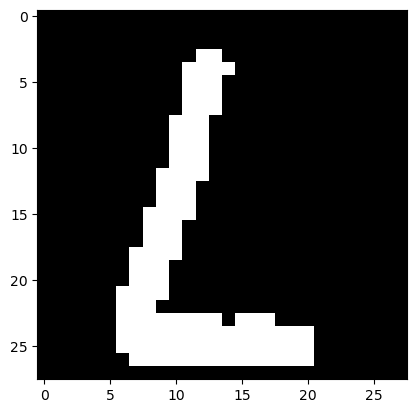

1/1 [==============================] - 0s 78ms/step


In [58]:
conts = find_contours(processed_img.copy())
characters = []
for c in conts:
    (x, y, w, h) = cv2.boundingRect(c)
    if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
        process_box(gray, x, y, w, h)

boxes = [b[1] for b in characters]
pixels = np.array([p[0] for p in characters], dtype="float32")
predictions = network.predict(pixels)

In [59]:
# A quick and dirty way to handle the confusion
# 1-I, 5-S, 0-O, we can
# 1. if letters are surrounded by letters, change numbers for letters
# 2. change the confusing numbers in the number list to be letters
digits_2 = 'OI234S6789'
letters_2 = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
characters_list_2 = digits_2 + letters_2
characters_list_2 = [l for l in characters_list_2]

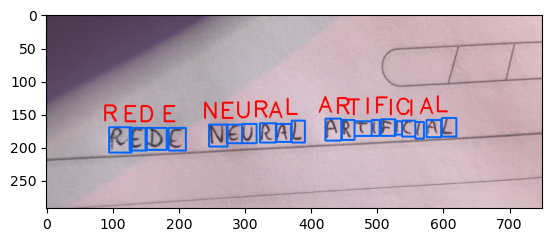

In [60]:
img_cp = img.copy()
for (pred, (x, y, w, h)) in zip(predictions, boxes):
  i, probability, character = prediction(pred, characters_list_2)
  draw_img(img_cp, character)
cv2_imshow(img_cp)

## Problems with undetected texts

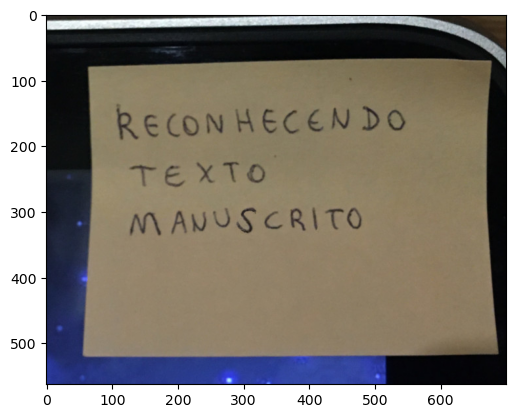

In [61]:
img = cv2.imread(DATA_PATH+'Images/test_manuscript03.jpg')
cv2_imshow(img)

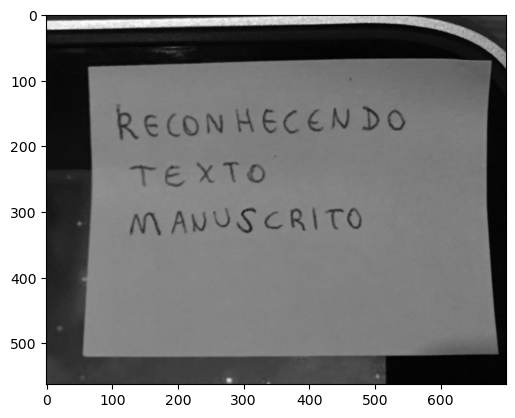

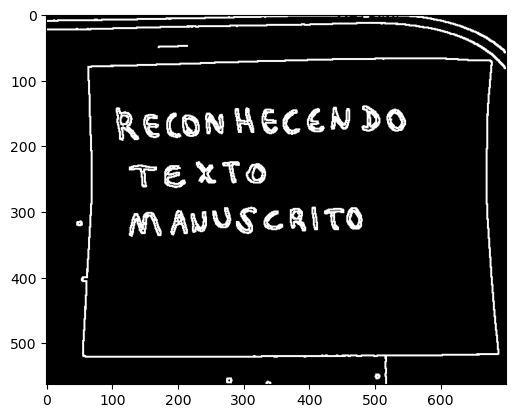

In [62]:
gray, processed_img = preprocess_img(img)
cv2_imshow(gray)
cv2_imshow(processed_img)

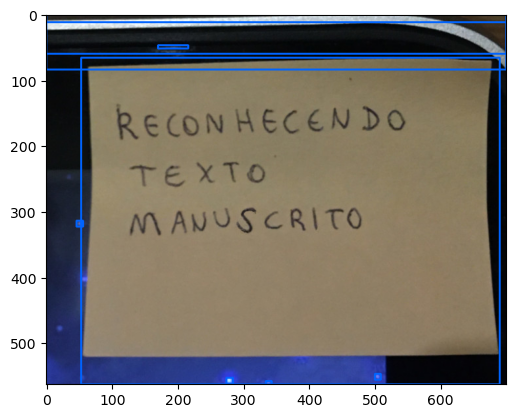

In [63]:
conts = find_contours(processed_img.copy()) # RETR_EXTERNAL
img_cp = img.copy()
for c in conts:
    (x, y, w, h) = cv2.boundingRect(c)
    #if (w >= l_min and w <= l_max) and (h >= a_min and h <= a_max):
    roi = gray[y:y + h, x:x + w]
    thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    cv2.rectangle(img_cp, (x, y), (x + w, y + h), (255, 100, 0), 2)
cv2_imshow(img_cp)

In [64]:
height, width = img.shape[:2]
print(height, width)

563 700


In [65]:
contours_size = sorted(conts, key=cv2.contourArea, reverse=True)
contours_size

[array([[[500,  66]],
 
        [[499,  67]],
 
        [[435,  67]],
 
        [[434,  68]],
 
        [[397,  68]],
 
        [[396,  69]],
 
        [[363,  69]],
 
        [[362,  70]],
 
        [[321,  70]],
 
        [[320,  71]],
 
        [[292,  71]],
 
        [[291,  72]],
 
        [[256,  72]],
 
        [[255,  73]],
 
        [[234,  73]],
 
        [[233,  74]],
 
        [[203,  74]],
 
        [[202,  75]],
 
        [[167,  75]],
 
        [[166,  76]],
 
        [[138,  76]],
 
        [[137,  77]],
 
        [[ 98,  77]],
 
        [[ 97,  78]],
 
        [[ 68,  78]],
 
        [[ 67,  79]],
 
        [[ 63,  79]],
 
        [[ 63, 101]],
 
        [[ 64, 102]],
 
        [[ 64, 122]],
 
        [[ 65, 123]],
 
        [[ 65, 156]],
 
        [[ 66, 157]],
 
        [[ 66, 184]],
 
        [[ 67, 185]],
 
        [[ 67, 208]],
 
        [[ 68, 209]],
 
        [[ 68, 287]],
 
        [[ 67, 288]],
 
        [[ 67, 304]],
 
        [[ 66, 305]],
 
        [[ 66, 3

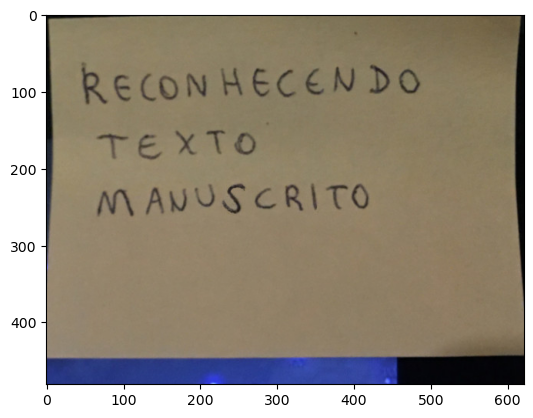

In [66]:
# The first contour ROI has no letters because
# a large contour is detected which contains the letter contours.
# Since we used the parameter to get external contours only in findContours(),
# the contained small letters are ignored.
# To adress that, the largest returned contour is taken and the ROI contained
# in it extracted. Then, the letter bounding boxes in that ROI are
# extracted as before.
for c in contours_size:
    (x, y, w, h) = cv2.boundingRect(c)
    
    if (w >= (width / 2)) and (h >= height / 2):
        cut_off = 8
        cut_img = img[y+cut_off:y + h - cut_off, x+cut_off:x + w - cut_off]
        cv2_imshow(cut_img)

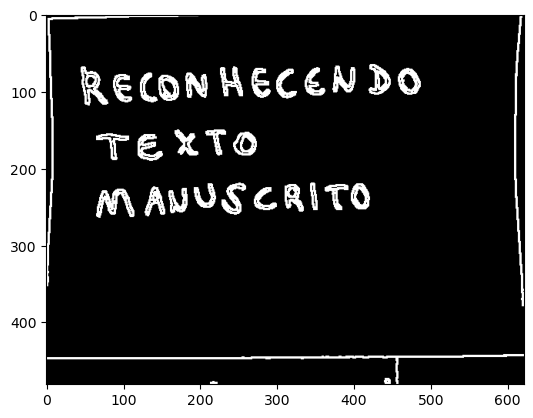

In [67]:
gray, processed_img = preprocess_img(cut_img)
cv2_imshow(processed_img)

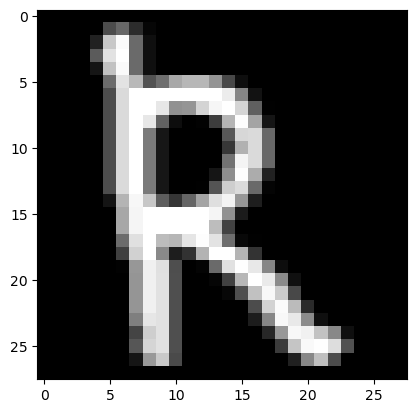

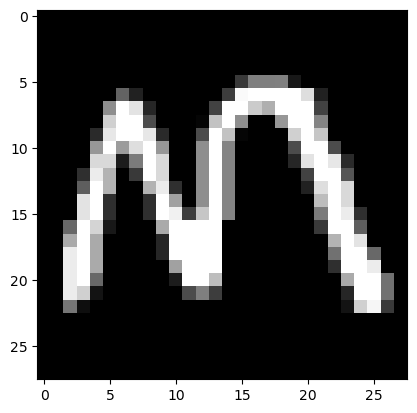

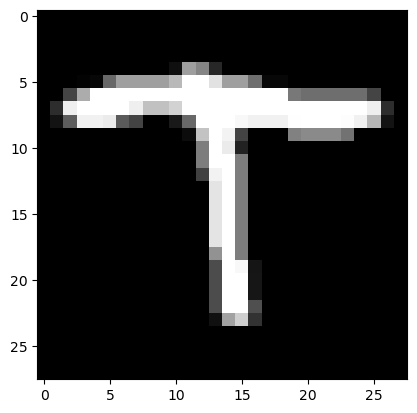

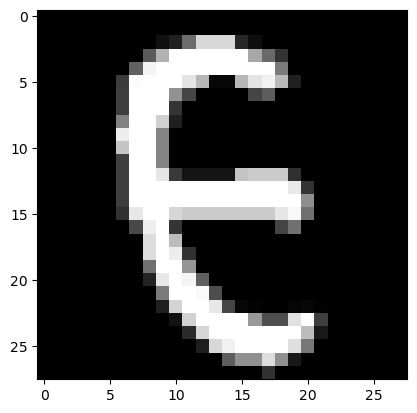

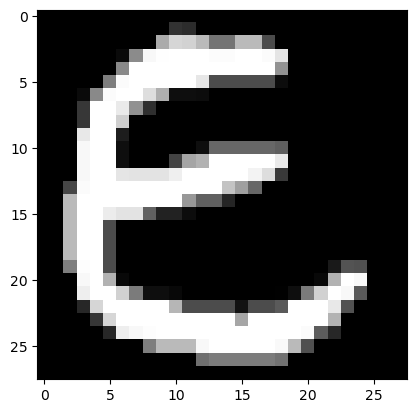

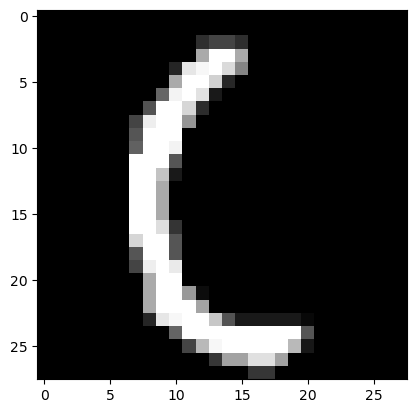

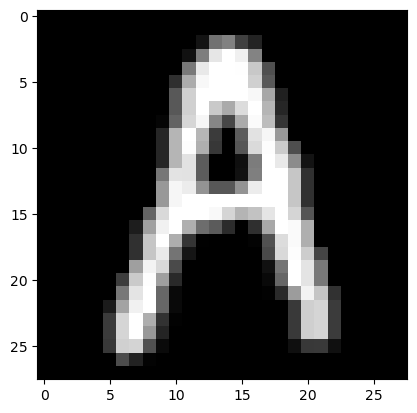

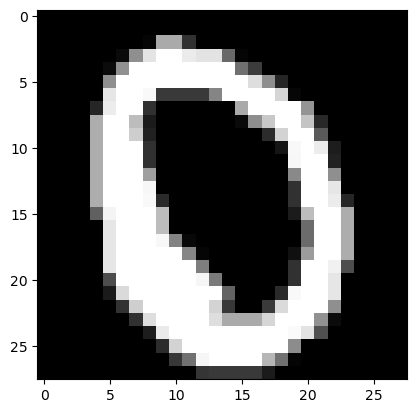

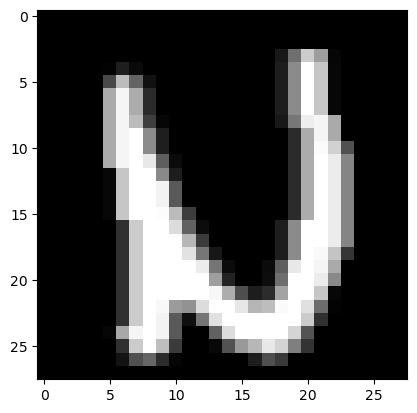

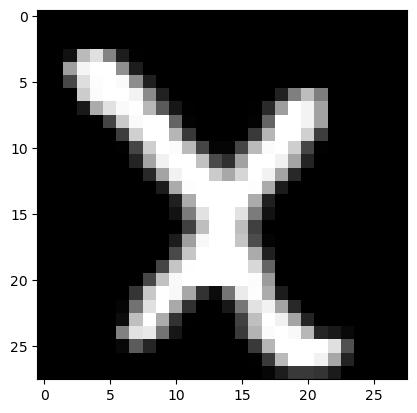

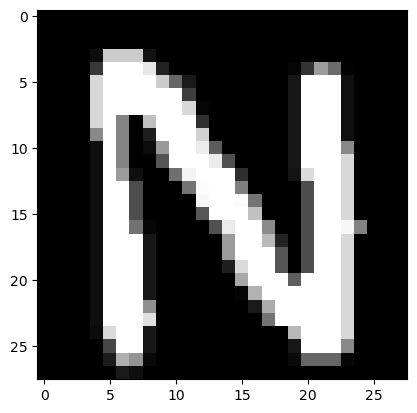

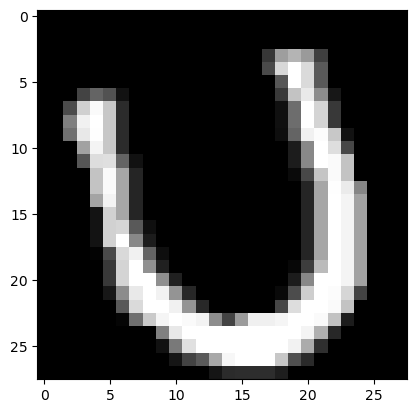

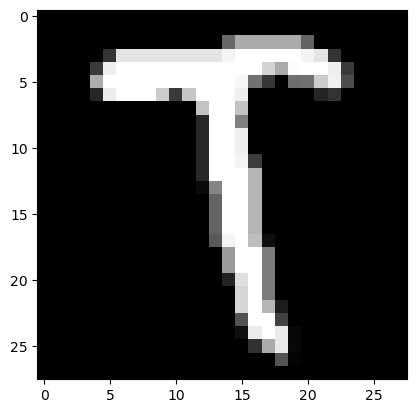

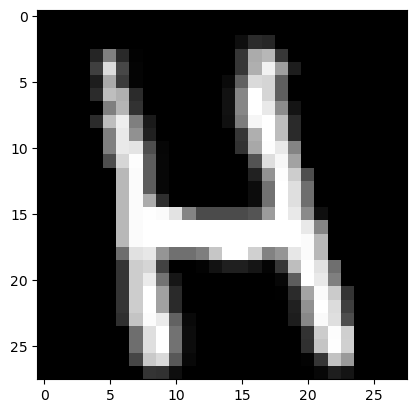

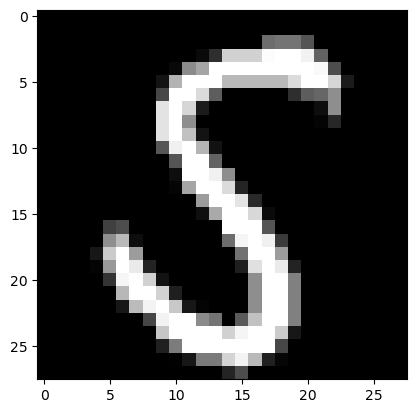

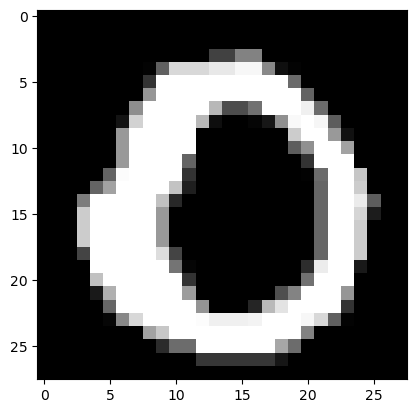

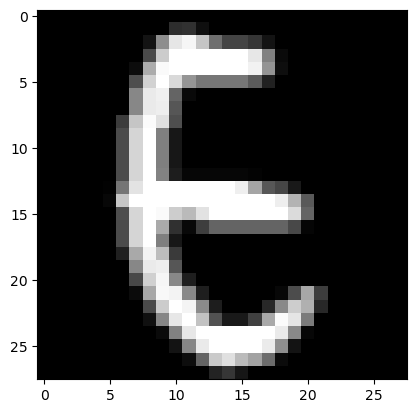

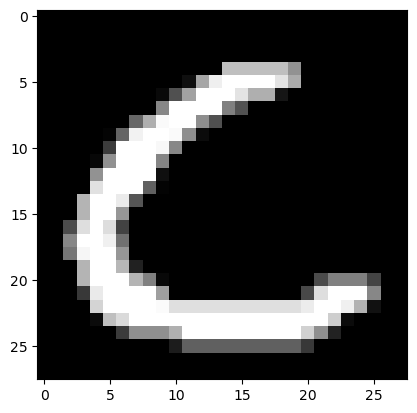

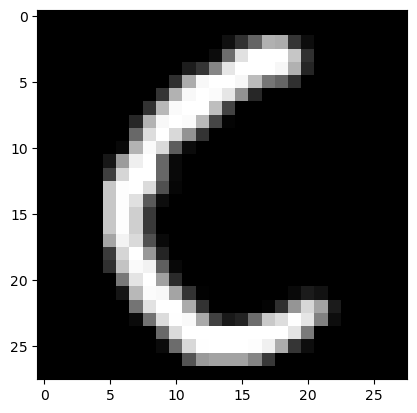

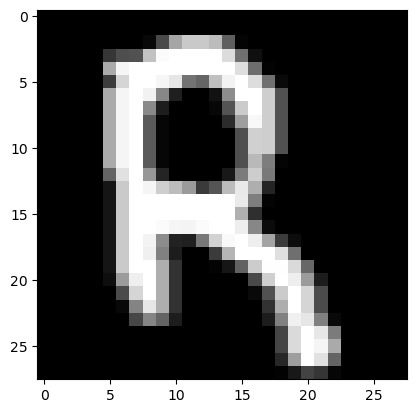

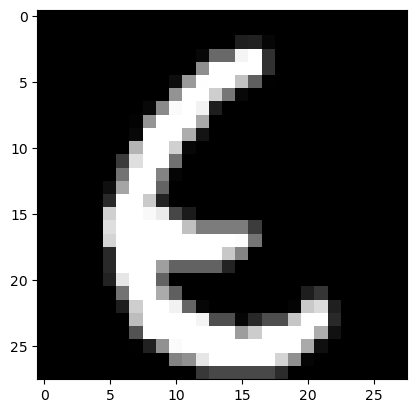

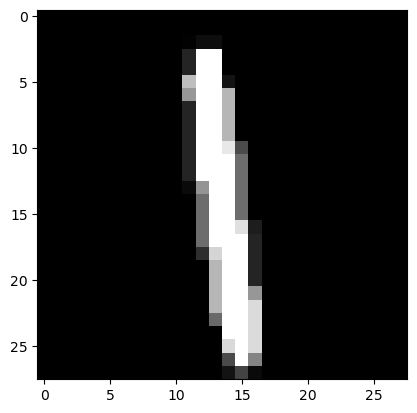

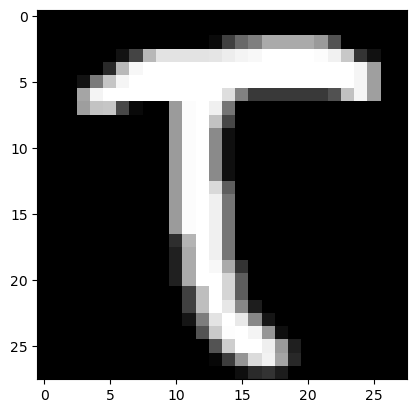

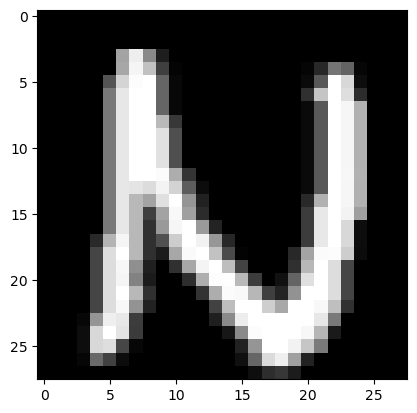

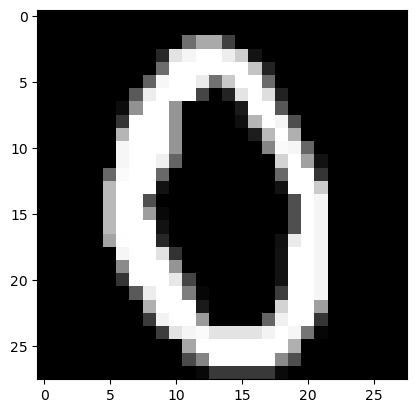

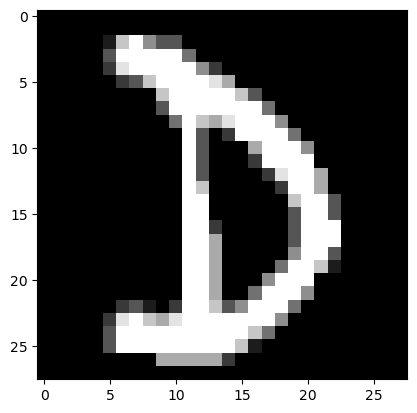

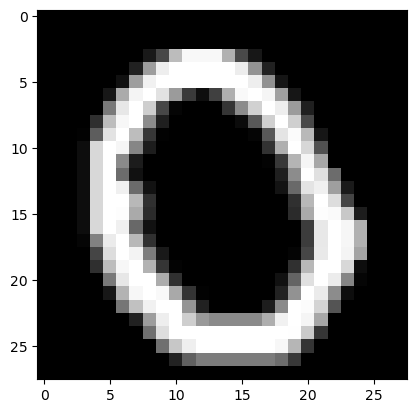

1/1 [==============================] - 0s 76ms/step


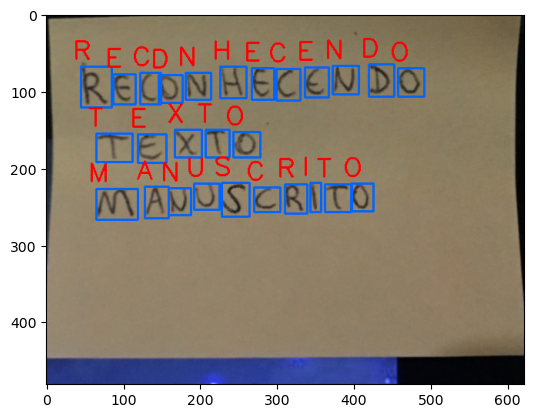

In [68]:
conts = find_contours(processed_img.copy())
characters = []
for c in conts:
    (x, y, w, h) = cv2.boundingRect(c)
    if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
        process_box(gray, x, y, w, h)

boxes = [b[1] for b in characters]
pixels = np.array([p[0] for p in characters], dtype="float32")
predictions = network.predict(pixels)

img_cp = cut_img.copy()
for (pred, (x, y, w, h)) in zip(predictions, boxes):
    i, probability, character = prediction(pred, characters_list_2)
    draw_img(img_cp, character)
cv2_imshow(img_cp)